In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('carclaims.csv')
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

No     14497
Yes      923
Name: FraudFound, dtype: int64


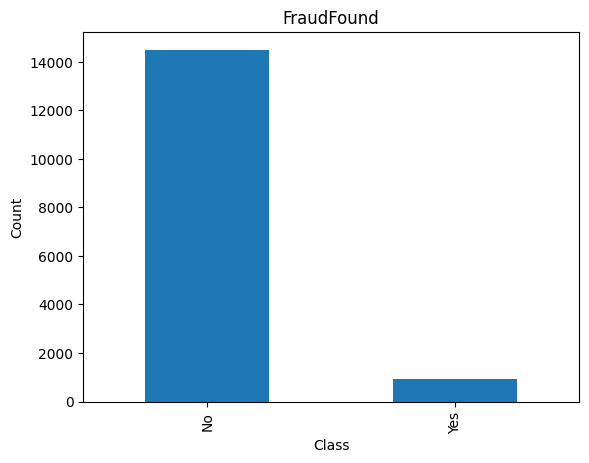

In [ ]:
y = df['FraudFound']
X = df.drop(['FraudFound'], axis=1)

counts = y.value_counts()
print(counts)

counts.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('FraudFound')

plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

X = one_hot_encoder.fit_transform(X)
scaler = MinMaxScaler() #StandardScaler()
X = scaler.fit_transform(X)

## Synthetic oversampling 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

algs = []
svm = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([svm, "Linear SVM"])
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])


for c, d in algs:
    print("\n" + d)
    # Create a pipeline
    pipeline = make_pipeline(c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

    # Create a pipeline
    pipeline2 = make_pipeline(SMOTE(random_state=0, k_neighbors=5),c)
    pipeline2.fit(X_train, y_train)

    # Classify and report the results
    print("with SMOTE")
    print(classification_report_imbalanced(y_test, pipeline2.predict(X_test)))



Linear SVM
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.08      0.01      4349
        Yes       0.67      0.01      1.00      0.01      0.08      0.01       277

avg / total       0.92      0.94      0.07      0.91      0.08      0.01      4626

with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

         No       0.99      0.65      0.84      0.78      0.74      0.54      4349
        Yes       0.13      0.84      0.65      0.23      0.74      0.56       277

avg / total       0.93      0.66      0.83      0.75      0.74      0.54      4626


Random Forest
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.10      0.01      4349
        Yes       0.60      0.01      1.00      0.02      0.10      0.01       277

avg / total       0.92      0.94      0.0

If we mainly focus on geometric mean (geo) metric, it is evident that SMOTE helps, as the metric is increased. In particular,we observe that the linear SVM model has the highest improvement in the geo metric after applying SMOTE, while the smallest increase is observed in the Random Forest model. 

Linear SVM is a linear classification model that tries to find a hyperplane that best separates the classes. When the classes are imbalanced, the SVM tries to maximize the margin around the minority class by ignoring some of the majority class samples. This can lead to poor sensitivity (recall) and low geometric mean, as observed in the first table of the results. However, when SMOTE is applied, it increases the number of minority class samples, which improves the geo and the overall performance of the model.

Random Forest, is an ensemble method that combines multiple decision trees to make a final prediction. When SMOTE is applied, it increases the number of minority class samples, which helps to balance the classes. However, the improvement in the geo metric may not be as significant as in other models.

## Easy ensemble

### SVM

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter


scoring = ['accuracy', 'balanced_accuracy']

algs = []
lsvc = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([lsvc, "Linear SVM"])
lsvc2 = LinearSVC(loss='squared_hinge', random_state=0, class_weight='balanced')
algs.append([lsvc2, "Linear SVM with balanced class weights"])
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])

for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))


Linear SVM
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)

Linear SVM with balanced class weights
accuracy: 0.63 (+/- 0.02)
balanced_accuracy: 0.65 (+/- 0.07)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


In the case of Linear SVM, the balanced accuracy score is 0.50 for the model without balanced class weights, indicating poor performance in handling imbalanced classes. However, the model with balanced class weights shows an improvement in balanced accuracy, with a score of 0.65. The easy ensemble method shows a balanced accuracy score of 0.61, which is slightly lower than the balanced class weights model.

### Random Forest

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier


scoring = ['accuracy', 'balanced_accuracy']

algs = []
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
rf2 = RandomForestClassifier(criterion='gini', random_state=0, class_weight='balanced')
algs.append([rf2, "Random Forest with balanced class weights"])
rf3 = BalancedRandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf3, "Balanced Random Forest Classifier"])
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])

for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))        


Random Forest
accuracy: 0.93 (+/- 0.02)
balanced_accuracy: 0.51 (+/- 0.03)

Random Forest with balanced class weights
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)

Balanced Random Forest Classifier
accuracy: 0.64 (+/- 0.03)
balanced_accuracy: 0.66 (+/- 0.05)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


The main difference between RandomForestClassifier with class_weight='balanced' and BalancedRandomForestClassifier lies in how they handle imbalanced datasets.
RandomForestClassifier with class_weight='balanced' assigns weights to the classes inversely proportional to their frequency in the training data. This means that the algorithm gives more weight to the minority class and less weight to the majority class. 
BalancedRandomForestClassifier, on the other hand, uses a different approach to address class imbalance. It performs random under-sampling of the majority class at each bootstrap iteration of the decision tree construction. This means that the algorithm will train each decision tree on a balanced subset of the data, which should result in better performance for both the minority and majority classes.

If we focus and compare the balanced accuracies, its seems that Random Forest with balanced class weights does not help improve the balanced_accuracy, but Balanced Random Forest Classifier and easy ensemble do. However easy ensemble does not outperform Balanced Random Forest Classifier.

### Naive Bayes

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter


scoring = ['accuracy', 'balanced_accuracy']

algs = []
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])
cnb = ComplementNB(force_alpha=True)
algs.append([cnb, "Complement Naive Bayes"]) # particularly suited for imbalanced data sets
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])


for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))       


Naive Bayes
accuracy: 0.10 (+/- 0.01)
balanced_accuracy: 0.51 (+/- 0.00)

Complement Naive Bayes
accuracy: 0.62 (+/- 0.02)
balanced_accuracy: 0.65 (+/- 0.04)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


The Complement Naive Bayes (CNB) classifier is an extension of the traditional Naive Bayes (NB) classifier. It is designed to work better with imbalanced datasets, where the majority class dominates the training set.

Once again the easy ensemble method can increase the balanced_accuracy. However, using the Complement Naive Bayes could give better results.

Overall, we can see that other models that handle imbalanced datasets tend to perform better compared to the easy ensemble method.

## Cluster-Based Sampling


In [ ]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

undersampler = ClusterCentroids()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

algs = []
svm = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([svm, "Linear SVM"])
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])


for c, d in algs:
    print("\n" + d)
    # Create a pipeline
    pipeline = make_pipeline(c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

    # Create a pipeline
    pipeline = make_pipeline(undersampler,c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print("with Cluster Centroids Undersampling")
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))



Linear SVM
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.08      0.01      4349
        Yes       0.67      0.01      1.00      0.01      0.08      0.01       277

avg / total       0.92      0.94      0.07      0.91      0.08      0.01      4626

with Cluster Centroids Undersampling
                   pre       rec       spe        f1       geo       iba       sup

         No       0.99      0.60      0.92      0.75      0.74      0.53      4349
        Yes       0.13      0.92      0.60      0.22      0.74      0.57       277

avg / total       0.94      0.62      0.90      0.72      0.74      0.54      4626


Random Forest
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.10      0.01      4349
        Yes       0.60      0.01      1.00      0.02      0.10      0.01       277

avg / total    

In two out of the three cases (Naive Bayes and Linear SVM), the geometric mean (geo) increases when using Cluster Centroids undersampling compared to not using it. The Cluster Centroids algorithm works by clustering the majority class examples and then generating artificial data points in the clusters' centroids to balance the dataset.

When combined with Naive Bayes and Linear SVM, Cluster Centroids can help because these classifiers are sensitive to imbalanced data. By balancing the dataset using Cluster Centroids, these classifiers can achieve better performance because they can learn more representative decision boundaries for both classes.

On the other hand, Random Forest is an ensemble learning algorithm that builds multiple decision trees and combines their outputs. Each tree is trained on a random subset of the data, and the final prediction is made by taking the majority vote of the trees. Because of this, Random Forest can handle imbalanced data well and without the need for additional techniques like Cluster Centroids. Therefore, combining Cluster Centroids with Random Forest may not have a significant impact on performance.